## Setup

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm
from google.colab import files
import math
import os
import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'device = {device}')

device = cpu


In [ ]:
# Explicit Runge-Kutta4
def ERK4(f, T_data, n, start):

    h = T_data / n
    x0, y0, z0 = start
    t_values = np.linspace(0, T_data, n+1)
    u_values = np.zeros((n+1, 3))
    u_values[0] = [x0, y0, z0]

    for i in range(n):
        t, x, y, z = t_values[i], *u_values[i]
        k1 = h * f(t, x, y, z)
        k2 = h * f(t + h / 2, x + k1[0] / 2, y + k1[1] / 2, z + k1[2] / 2)
        k3 = h * f(t + h / 2, x + k2[0] / 2, y + k2[1] / 2, z + k2[2] / 2)
        k4 = h * f(t + h, x + k3[0], y + k3[1], z + k3[2])
        u_values[i+1] = u_values[i] + (k1 + 2*k2 + 2*k3 + k4) / 6

    return t_values, u_values

    # t \in [0, T]
    # u_values[:, 0] -> S(t), u_values[:, 1] -> I(t), u_values[:, 2] -> R(t)

In [ ]:
# SIR plotter
def draw(f, T_data, n, start, T_model=None):
    plt.figure(figsize=(10, 5))
    t, u = ERK4(f, T_data, n, start)
    x, y, z = u.T

    plt.plot(t, x, label='Susceptible', c='b')
    plt.plot(t, y, label='Infected', c='r')
    plt.plot(t, z, label='Recovered', c='y')
    if T_model:
        plt.axvline(T_model, linestyle='--', color='k', label='Model Training Limit')

    plt.title('Simulation with RK4')
    plt.xlabel('Time')
    plt.ylabel('Population Fraction')
    plt.legend()
    plt.show()

In [ ]:
#Residual loss getter
def residual_loss(model, t_values):

    t_values.requires_grad_(True)
    beta = model.beta
    gamma = model.gamma
    predictions = model(t_values)
    S, I, R = predictions[:, 0], predictions[:, 1], predictions[:, 2]

    dS_dt = torch.autograd.grad(S.sum(), t_values, create_graph=True)[0]
    dI_dt = torch.autograd.grad(I.sum(), t_values, create_graph=True)[0]
    dR_dt = torch.autograd.grad(R.sum(), t_values, create_graph=True)[0]

    loss_S = dS_dt + beta * S * I
    loss_I = dI_dt - beta * S * I + gamma * I
    loss_R = dR_dt - gamma * I

    return 3 * (loss_S**2 + loss_I**2 + loss_R**2).mean()

In [ ]:
# gets the MSE values of train, test and 10-day test
def get_mse(model, t_all, u_all, T_model):
    model.eval()
    with torch.no_grad():
        t_all = t_all.to(device)
        predictions_all = model(t_all).cpu()
        predictions_all = predictions_all.squeeze(1)

    t_all_flat = t_all.squeeze(1).cpu()

    t_model = t_all_flat[t_all_flat <= T_model]
    u_model = u_all[t_all_flat <= T_model]

    t_test = t_all_flat[t_all_flat > T_model]
    u_test = u_all[t_all_flat > T_model]

    predictions_model = predictions_all[t_all_flat <= T_model]
    predictions_test = predictions_all[t_all_flat > T_model]

    t_10 = t_test[t_test <= T_model + 10]
    u_10 = u_test[t_test <= T_model + 10]
    predictions_10 = predictions_test[t_test <= T_model + 10]

    mse = nn.MSELoss()

    train_loss = mse(predictions_model, u_model).item()
    test_loss = mse(predictions_test, u_test).item()
    mse_10 = mse(predictions_10, u_10).item()

    return train_loss, test_loss, mse_10

In [ ]:
# Plots the change of loss
def plot_losses(epoch_losses):

    epochs = range(len(epoch_losses['total_loss']))
    plt.figure(figsize=(10, 5))

    plt.plot(epochs, epoch_losses['data_loss'],     label="Data Loss",     c='b')
    plt.plot(epochs, epoch_losses['residual_loss'], label="Residual Loss", c='r')
    plt.plot(epochs, epoch_losses['total_loss'],    label="Total Loss",    c='yellowgreen')

    plt.xlabel("Epochs")
    plt.ylabel("Loss (Log Scale)")

    plt.yscale('log')
    plt.title("Loss")
    plt.legend()
    plt.show()

In [ ]:
# Plots the predictions of a model
def plot_results(model, t, u, T_model, num_points=40, use_model=True, title=None):

    plt.figure(figsize=(10, 5))
    indices = torch.linspace(0, len(t) - 1, steps=num_points, dtype=torch.long)

    t = t.detach().cpu()
    u = u.detach().cpu()

    t_sampled = t[indices]
    u_sampled = u[indices]

    if use_model:
        model.eval()
        with torch.no_grad():
            t_ = t_sampled.unsqueeze(1).to(device)
            predictions = model(t_).cpu()
            predictions = predictions.squeeze(1)

        plt.plot(t_sampled, predictions[:, 0], label='Susceptible (NN)', c='blueviolet', lw=2.5, alpha=0.7, marker='o', markersize=6)
        plt.plot(t_sampled, predictions[:, 1], label='Infected (NN)', c='orangered', lw=2.5, alpha=0.7, marker='o', markersize=6)
        plt.plot(t_sampled, predictions[:, 2], label='Recovered (NN)', c='gold', lw=2.5, alpha=0.7, marker='o', markersize=6)

    plt.axvline(T_model, linestyle='--', color='k', label='Model Training Limit')

    if title is not None:
        plt.title(title)

        plt.plot(t_sampled, u_sampled[:, 0], label='Susceptible (Data)', c='midnightblue', lw=2.5)
        plt.plot(t_sampled, u_sampled[:, 1], label='Infected (Data)', c='firebrick', lw=2.5)
        plt.plot(t_sampled, u_sampled[:, 2], label='Recovered (Data)', c='yellowgreen', lw=2.5)
    else:
        plt.title('PINN SIR Model Prediction vs RK4 Simulation')

        plt.plot(t_sampled, u_sampled[:, 0], label='Susceptible (RK4)', c='midnightblue', lw=2.5)
        plt.plot(t_sampled, u_sampled[:, 1], label='Infected (RK4)', c='firebrick', lw=2.5)
        plt.plot(t_sampled, u_sampled[:, 2], label='Recovered (RK4)', c='yellowgreen', lw=2.5)

    plt.xlabel('Time')
    plt.ylabel('Population Fraction')
    plt.legend()
    plt.show()

In [ ]:
# Training function
def train(model, t, u, num_epochs=40000, num_info_after_iter=1000, lr=1e-3, wd=0.0,
          weight_data=1.0, weight_res=1.0, plot_loss=True, plot_rk4=True, plot_params=True, patience=2000):

    if wd:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    mse_loss = nn.MSELoss()
    epoch_losses = {'data_loss': [], 'residual_loss': [], 'total_loss': []}
    best_loss = float('inf')
    best_data_loss = float('inf')
    best_res_loss = float('inf')
    patience_counter = 0
    t_train, u_train = t.to(device), u.to(device)
    model.to(device)
    model.train()

    for epoch in tqdm(range(num_epochs)):

        optimizer.zero_grad()
        predictions = model(t)
        data_loss = mse_loss(predictions, u)
        res_loss = residual_loss(model, t)
        total_loss = weight_data * data_loss.mean() + weight_res * res_loss.mean()

        total_loss.backward()
        optimizer.step()

        epoch_losses['data_loss'].append(data_loss.item())
        epoch_losses['residual_loss'].append(res_loss.mean().item())
        epoch_losses['total_loss'].append(total_loss.item())

        if not (epoch + 1) % num_info_after_iter:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Data Loss: {data_loss.item():.10f} | Residual Loss: {res_loss.mean().item():.10f} | Total Loss: {total_loss.item():.10f}")

        # Early Stopping
        if total_loss < best_loss:
            best_loss = total_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'parameters.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in the last {patience} epochs.")
            break

    model.load_state_dict(torch.load('parameters.pth'))
    print(f"Stopping with best Total Loss: {best_loss:.10f}")

    if plot_loss:
        plot_losses(epoch_losses)

    if plot_rk4: # First dataset
        plot_results(model, t_tensor, u_tensor, T_model, title='PINN SIR Model Prediction vs RK4 Dataset')
        train_loss, test_loss, ten_loss = get_mse(model, t_tensor, u_tensor, 40)
    else:        # Second dataset
        plot_results(model, t_tensor_covid, u_tensor_covid, T_model_covid, title='PINN SIR Model Prediction vs Covid19 Dataset')
        train_loss, test_loss, ten_loss = get_mse(model, t_tensor_covid, u_tensor_covid, 45)

    if plot_params:
        print(f"Beta: {model.beta.item()}")
        print(f"Gamma: {model.gamma.item()}")

    # Results
    print(f"Train Loss: {train_loss:.10f}")
    print(f"Test Loss: {test_loss:.10f}")
    print(f"10 Day Loss: {ten_loss:.10f}")

    #return epoch_losses

t_tensor.shape = torch.Size([81, 1])
u_tensor.shape = torch.Size([81, 3])
t_model.shape = torch.Size([41, 1])
u_model.shape = torch.Size([41, 3])


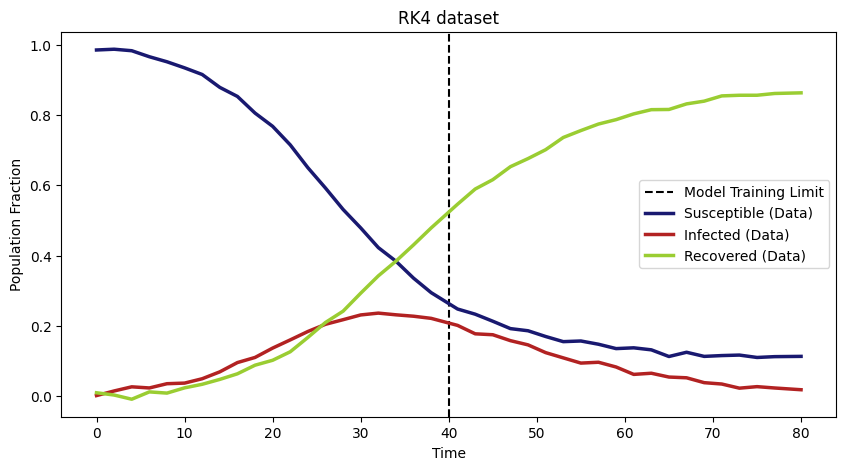

In [2]:
# Data generation

beta = 0.25
gamma = 0.1
start = [0.99, 0.01, 0.00]
T_data = 80
T_model = 40
n = 80

def SIR(t, S, I, R):
    dS = -beta * S * I
    dI = beta * S * I - gamma * I
    dR = gamma * I
    return np.array([dS, dI, dR])

t_numpy, u_numpy = ERK4(SIR, T_data, n, start)
#draw(SIR, T_data, n, start)

noise_level = 0.005
u_numpy += np.random.normal(0, noise_level, u_numpy.shape)

t_tensor = torch.tensor(t_numpy, dtype=torch.float32).unsqueeze(1)
u_tensor = torch.tensor(u_numpy, dtype=torch.float32)

t_model = torch.tensor(t_numpy[t_numpy <= T_model], dtype=torch.float32).unsqueeze(1)
u_model = torch.tensor(u_numpy[t_numpy <= T_model], dtype=torch.float32)

print(f't_tensor.shape = {t_tensor.shape}')
print(f'u_tensor.shape = {u_tensor.shape}')
print(f't_model.shape = {t_model.shape}')
print(f'u_model.shape = {u_model.shape}')

plot_results(None, t_tensor, u_tensor, T_model, use_model=False, title='RK4 dataset')

## Covid data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load data
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=["date"])
df = df[df["location"] == "United States"]

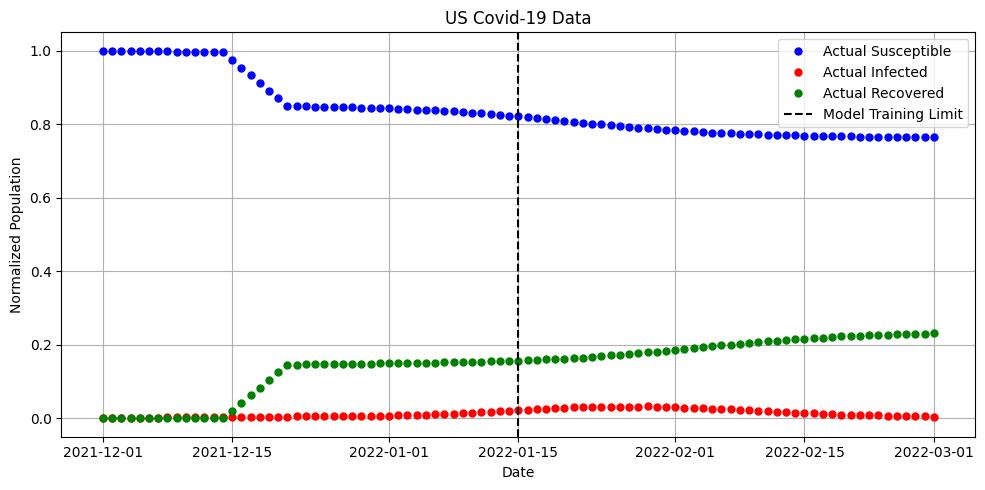

In [ ]:
# Use one wave
start_date, end_date = "2021-12-01", "2022-03-01"
df = df[(df["date"] >= start_date) & (df["date"] <= end_date)].copy()

N = 331_000_000  # US population

# Estimate compartments
infectious_period = 14

#df["new_cases_smoothed"] = df["new_cases"].rolling(7, min_periods=1).mean()
df["I"] = df["new_cases_smoothed"].rolling(infectious_period, min_periods=1).sum()

df["R"] = df["total_cases"].shift(infectious_period).fillna(0)
df["R"] = df["R"].rolling(7, min_periods=1).mean()  # smooth recovery
df["S"] = N - df["I"] - df["R"]

# Normalize
df["S_norm"] = df["S"] / N
df["I_norm"] = df["I"] / N
df["R_norm"] = df["R"] / N

# Time in days
df["t"] = (df["date"] - df["date"].min()).dt.days
t = df["t"].values
S_obs = df["S_norm"].values
I_obs = df["I_norm"].values
R_obs = df["R_norm"].values

dates = df["date"]

# Plot
plt.figure(figsize=(10, 5))

plt.plot(dates, S_obs, "o", markersize=5, label="Actual Susceptible", color="blue")
plt.plot(dates, I_obs, "o", markersize=5, label="Actual Infected", color="red")
plt.plot(dates, R_obs, "o", markersize=5, label="Actual Recovered", color="green")

plt.axvline(19007, linestyle='--', color='k', label='Model Training Limit')

plt.title(f"US Covid-19 Data")
plt.xlabel("Date")
plt.ylabel("Normalized Population")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

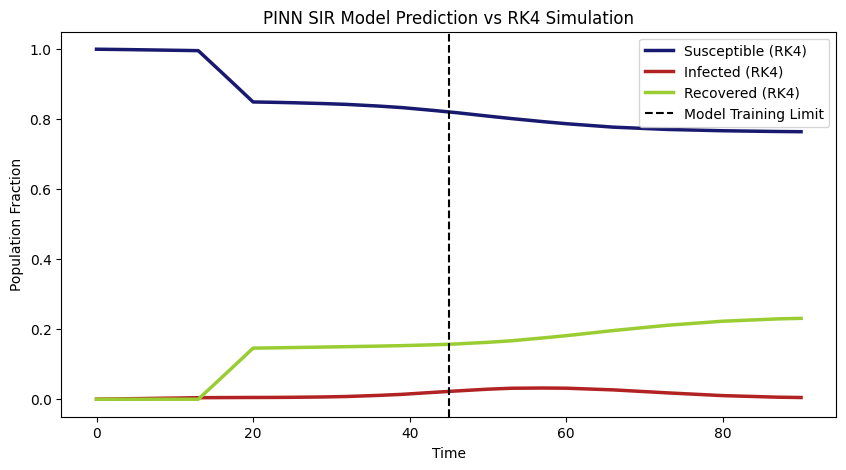

In [ ]:
plot_results(None, torch.tensor(t, dtype=torch.float32).unsqueeze(1), torch.tensor(df[["S_norm", "I_norm", "R_norm"]].values, dtype=torch.float32), 45, use_model=False)

In [ ]:
t_tensor_covid = torch.tensor(df["t"].values, dtype=torch.float32).unsqueeze(1)  # shape [x, 1]
u_tensor_covid = torch.tensor(df[["S_norm", "I_norm", "R_norm"]].values, dtype=torch.float32)  # shape [x, 3]

T_model_covid = 45
t_model_covid = t_tensor_covid[:t_tensor_covid.shape[0] // 2]  # shape [y, 1]
u_model_covid = u_tensor_covid[:t_tensor_covid.shape[0] // 2]  # shape [y, 3]

# Check
print("t_tensor.shape:", t_tensor_covid.shape)
print("u_tensor.shape:", u_tensor_covid.shape)
print("t_model.shape:", t_model_covid.shape)
print("u_model.shape:", u_model_covid.shape)

t_tensor.shape: torch.Size([91, 1])
u_tensor.shape: torch.Size([91, 3])
t_model.shape: torch.Size([45, 1])
u_model.shape: torch.Size([45, 3])


## MLP

In [ ]:
class PINNMLP(nn.Module):

    def __init__(self, input_size=1, output_size=3, hidden_size=64, num_layers=4, act_func=nn.ReLU(), beta=0.25, gamma=0.1, trainable=False):
        super(PINNMLP, self).__init__()

        if trainable:
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))
        else:
            self.beta = torch.tensor(beta, dtype=torch.float32)
            self.gamma = torch.tensor(gamma, dtype=torch.float32)

        self.fc_in = nn.Linear(input_size, hidden_size)
        self.hidden_layers = nn.ModuleList([nn.Linear(hidden_size, hidden_size) for _ in range(num_layers - 2)])
        self.fc_out = nn.Linear(hidden_size, output_size)
        self.act_func = act_func

    def forward(self, x):
        x = self.act_func(self.fc_in(x))
        for layer in self.hidden_layers:
            x = self.act_func(layer(x))
        x = self.fc_out(x)
        return x

  5%|▌         | 516/10000 [00:05<00:52, 181.89it/s]

Epoch [500/10000] | Data Loss: 0.0006127899 | Residual Loss: 0.0011235639 | Total Loss: 0.0173635371


 10%|█         | 1021/10000 [00:08<01:04, 138.20it/s]

Epoch [1000/10000] | Data Loss: 0.0002177559 | Residual Loss: 0.0007623887 | Total Loss: 0.0098014455


 15%|█▌        | 1522/10000 [00:12<00:52, 162.80it/s]

Epoch [1500/10000] | Data Loss: 0.0002885760 | Residual Loss: 0.0005836783 | Total Loss: 0.0087225428


 17%|█▋        | 1672/10000 [00:13<01:07, 124.06it/s]


Early stopping at epoch 1673 due to no improvement in the last 100 epochs.
Stopping with best Total Loss: 0.0076709059


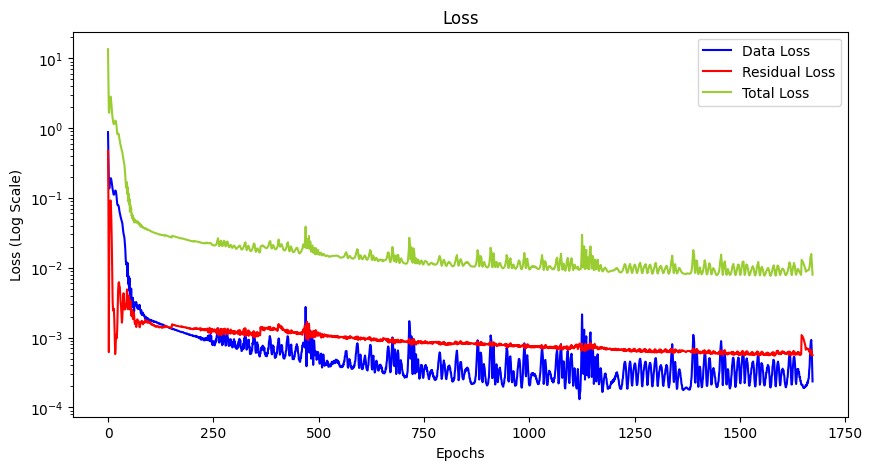

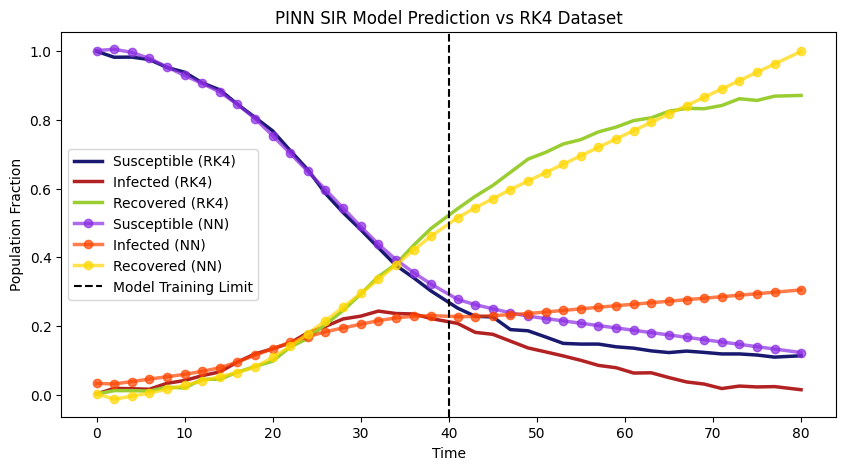

Beta: 0.22685706615447998
Gamma: 0.087901271879673
Train Loss: 0.0002027584
Test Loss: 0.0144671649
10 Day Loss: 0.0028315717


In [ ]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

mlp = PINNMLP(num_layers=4, act_func=nn.ReLU(), beta=0.2, gamma=0.2, trainable=True).to(device)
train(mlp, t_model, u_model, num_epochs=10000, num_info_after_iter=500, lr=1e-3, weight_data=10.0, weight_res=10.0, patience=100)

  5%|▌         | 532/10000 [00:02<00:49, 193.11it/s]

Epoch [500/10000] | Data Loss: 0.0002310890 | Residual Loss: 0.0001470759 | Total Loss: 0.0037816493


  8%|▊         | 845/10000 [00:04<00:50, 183.00it/s]


Early stopping at epoch 846 due to no improvement in the last 100 epochs.
Stopping with best Total Loss: 0.0024482773


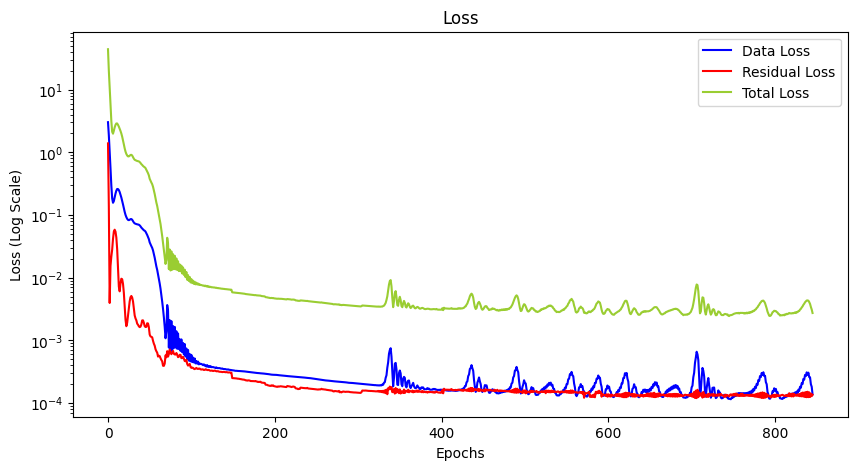

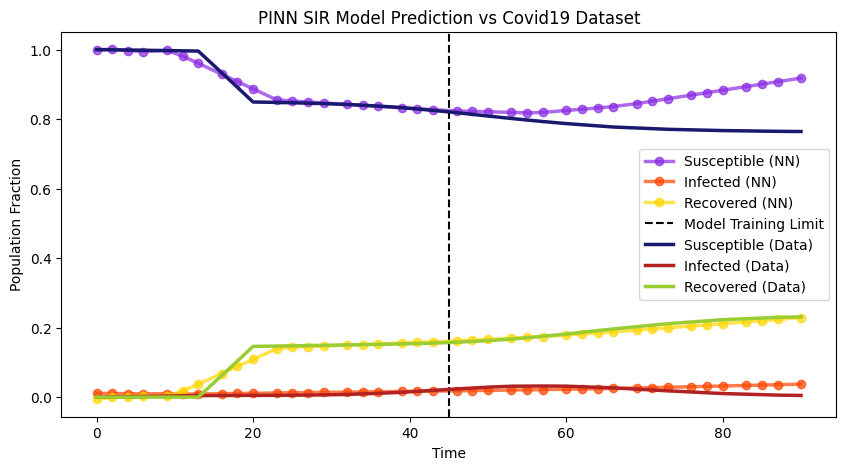

Beta: 0.19268687069416046
Gamma: 0.19170930981636047
Train Loss: 0.0001140400
Test Loss: 0.0025249436
10 Day Loss: 0.0000968052


In [ ]:
seed = 40
np.random.seed(seed)
torch.manual_seed(seed)

mlp_ = PINNMLP(num_layers=4, act_func=nn.ReLU(), beta=0.2, gamma=0.2, trainable=True).to(device)
train(mlp_, t_model_covid, u_model_covid, num_epochs=10000, num_info_after_iter=500, patience=100, lr=1e-3, weight_data=10, weight_res=10, plot_rk4=False)

## ResNet

 28%|██▊       | 284/1000 [00:03<00:09, 73.53it/s]


Early stopping at epoch 285 due to no improvement in the last 50 epochs.
Stopping with best Total Loss: 0.0076904548


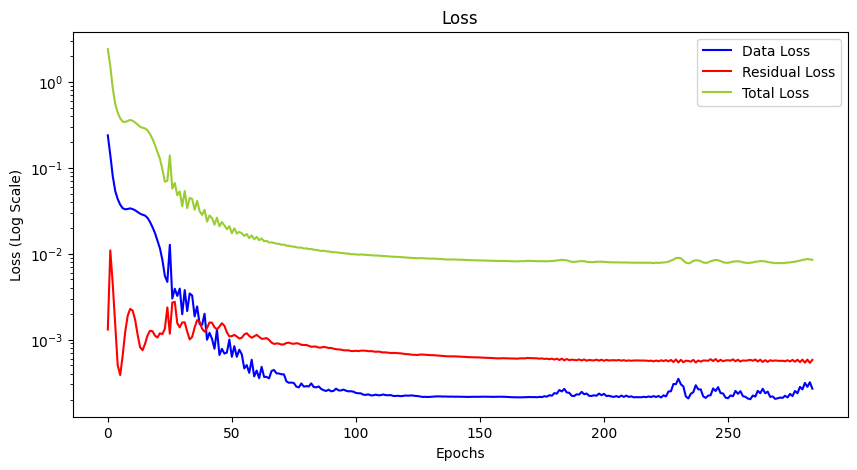

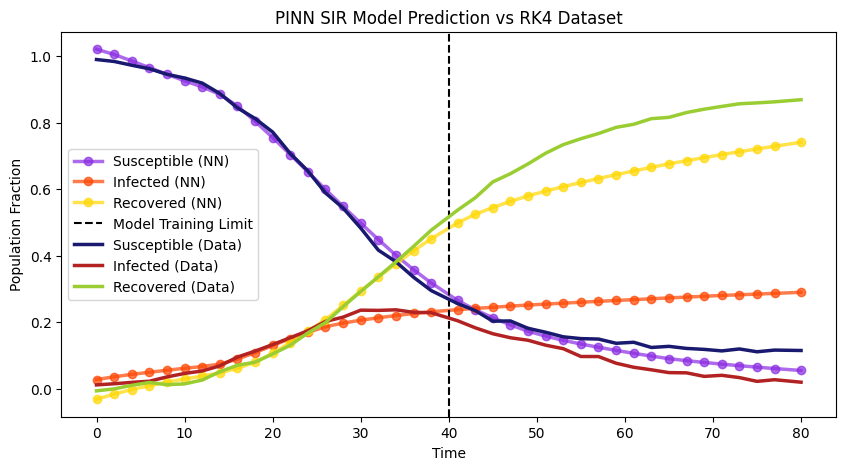

Beta: 0.21784701943397522
Gamma: 0.08133421093225479
Train Loss: 0.0002329821
Test Loss: 0.0180586558
10 Day Loss: 0.0042871912


In [ ]:
class ResidualBlock(nn.Module):

    def __init__(self, input_dim, output_dim, act_func):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_dim, output_dim)
        self.ln1 = nn.LayerNorm(output_dim)
        self.fc2 = nn.Linear(output_dim, output_dim)
        self.ln2 = nn.LayerNorm(output_dim)
        self.act_func = act_func

        self.shortcut = nn.Sequential()
        if input_dim != output_dim:
            self.shortcut = nn.Sequential(nn.Linear(input_dim, output_dim), nn.BatchNorm1d(output_dim))

    def forward(self, x):
        out = self.ln1(self.fc1(x))
        out = self.act_func(out)
        out = self.ln2(self.fc2(out))
        out += self.shortcut(x)
        out = self.act_func(out)
        return out


class PINN_SIR(nn.Module):

    def __init__(self, blocks=2, neurons=64, act_func=nn.ReLU(), beta=0.25, gamma=0.1, trainable=False):
        super(PINN_SIR, self).__init__()

        if trainable:                                                                # whether beta and gamma are learnable parameters
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))        #
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))      #
        else:                                                                        # or fixed scalars
            self.beta = torch.tensor(beta, dtype=torch.float32)
            self.gamma = torch.tensor(gamma, dtype=torch.float32)

        self.fc_in = nn.Linear(1, neurons)
        self.res_blocks = nn.Sequential(*[ResidualBlock(neurons, neurons, act_func) for _ in range(blocks)])
        self.fc_out = nn.Linear(neurons, 3)

        self.apply(self._initialize_weights)

    def _initialize_weights(self, m):
       if isinstance(m, nn.Linear):
           nn.init.normal_(m.weight, mean=0, std=0.01)
           nn.init.constant_(m.bias, 0)

    def forward(self, input):
        x = torch.relu(self.fc_in(input))
        x = self.res_blocks(x)
        output = self.fc_out(x)
        return output

pinn_ = PINN_SIR(blocks=2, neurons=64, act_func=nn.ReLU(), beta=0.2, gamma=0.2, trainable=True).to(device)
train(pinn_, t_model, u_model, num_epochs=1000, num_info_after_iter=500, lr=1e-3, weight_data=10.0, weight_res=10.0, patience=50)

In [ ]:
!pip install onnx
import onnx

dummy_input = torch.randn(1, t_model.shape[1])
torch.onnx.export(pinn, dummy_input, "model.onnx", input_names=["input"], output_names=["output"])

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 97.2 MB/s eta 0:00:00


 11%|█         | 112/1000 [00:01<00:12, 72.86it/s]

Epoch [100/1000] | Data Loss: 0.0002393854 | Residual Loss: 0.0000773193 | Total Loss: 0.0003167047


 21%|██        | 207/1000 [00:02<00:10, 78.71it/s]

Epoch [200/1000] | Data Loss: 0.0001162824 | Residual Loss: 0.0001188263 | Total Loss: 0.0002351087


 30%|███       | 302/1000 [00:04<00:09, 74.00it/s]


Epoch [300/1000] | Data Loss: 0.0001060031 | Residual Loss: 0.0001187853 | Total Loss: 0.0002247883
Early stopping at epoch 303 due to no improvement in the last 100 epochs.
Stopping with best Total Loss: 0.0002213426


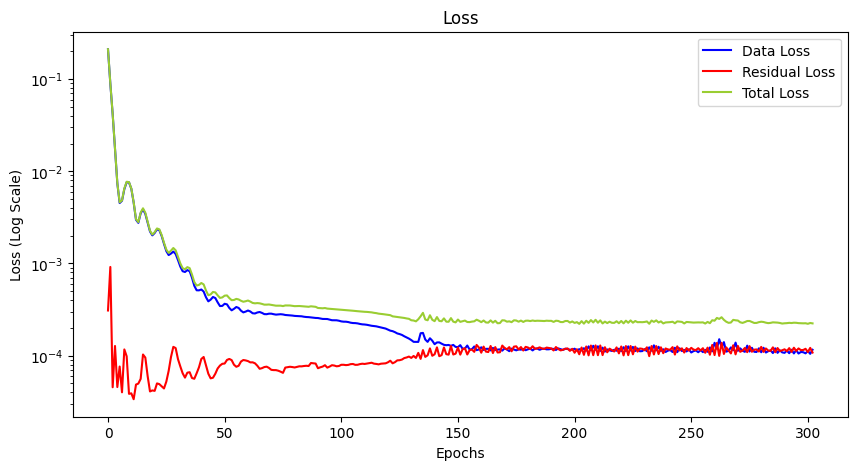

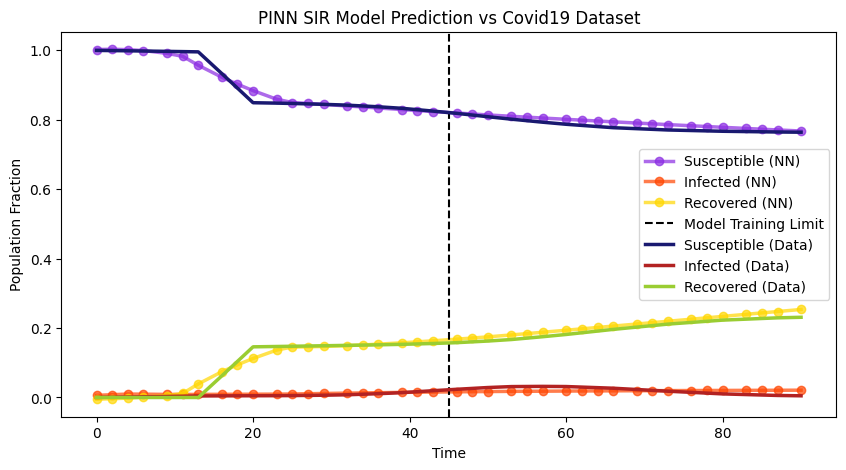

Beta: 0.29841136932373047
Gamma: 0.2363232523202896
Train Loss: 0.0001127673
Test Loss: 0.0001384391
10 Day Loss: 0.0001086688


In [ ]:
resnet = PINN_SIR(blocks=2, neurons=64, act_func=nn.ReLU(), beta=0.2, gamma=0.2, trainable=True).to(device)
train(resnet, t_model_covid, u_model_covid, num_epochs=1000, num_info_after_iter=100, lr=1e-3, weight_data=1.0, weight_res=1.0, patience=100, plot_rk4=False)

## RNN

In [ ]:
# Sequence creation from training data
def create_sequences(t_tensor, u_tensor, seq_length):
    X, y = [], []
    for i in range(len(t_tensor) - seq_length):
        X.append(t_tensor[i:i+seq_length])
        y.append(u_tensor[i:i+seq_length])
    return torch.stack(X), torch.stack(y)

seq_length = 10
t_seq, u_seq = create_sequences(t_model, u_model, seq_length)
t_seq_covid, u_seq_covid = create_sequences(t_model_covid, u_model_covid, seq_length)

In [ ]:
class PINNLSTM(nn.Module):

    def __init__(self, input_size=seq_length, output_size=3, hidden_size=128, num_layers=1, beta=beta, gamma=gamma, trainable=False):
        super(PINNLSTM, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)   # num_layers pcs of LSTM layers
        self.fc = nn.Linear(hidden_size, output_size)                                # one fully connected layer

        if trainable:                                                                # whether beta and gamma are learnable parameters
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))        #
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))      #
        else:                                                                        # or fixed scalars
            self.beta = beta
            self.gamma = gamma

    def forward(self, t):
        with torch.backends.cudnn.flags(enabled=False):                              # Temporarily disable CuDNN for the RNN forward pass
            lstm_out, _ = self.lstm(t)                                               # The LSTM layer outputs a tuple (output, (h_n, c_n)).
        predictions = self.fc(lstm_out)
        return predictions


class PINNGRU(nn.Module):
    def __init__(self, input_size=seq_length, output_size=3, hidden_size=128, num_layers=1, beta=beta, gamma=gamma, trainable=False):
        super(PINNGRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        if trainable:
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))
        else:
            self.beta = torch.tensor(beta)
            self.gamma = torch.tensor(gamma)

    def forward(self, t):
        with torch.backends.cudnn.flags(enabled=False):
            gru_out, _ = self.gru(t)
        predictions = self.fc(gru_out)
        return predictions


def train_rnn(model, t_train, u_train, num_epochs=20000, num_info_after_iter=1000, lr=1e-3, wd=0.0,
              weight_data=1.0, weight_res=1.0, weight_init=1.0, plot_loss=True, plot_rk4=True, plot_params=True, patience=2000):

    if wd:
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    else:
        optimizer = optim.Adam(model.parameters(), lr=lr)

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=200, factor=0.5)

    mse_loss = nn.MSELoss()
    epoch_losses = {'data_loss': [], 'residual_loss': [], 'init_loss': [], 'total_loss': []}
    best_loss = float('inf')
    patience_counter = 0
    t_train, u_train = t_train.to(device), u_train.to(device)
    model.to(device)
    model.train()

    for epoch in tqdm(range(num_epochs)):
        optimizer.zero_grad()
        predictions = model(t_train)

        init_loss = mse_loss(predictions[:, 0], u_train[:, 0])
        data_loss = mse_loss(predictions, u_train)
        res_loss = residual_loss(model, t_model.to(device))

        total_loss = weight_data * data_loss.mean() + weight_res * res_loss.mean() + weight_init * init_loss.mean()

        total_loss.backward()
        optimizer.step()
        scheduler.step(total_loss)

        epoch_losses['data_loss'].append(data_loss.item())
        epoch_losses['residual_loss'].append(res_loss.mean().item())
        epoch_losses['init_loss'].append(init_loss.item())
        epoch_losses['total_loss'].append(total_loss.item())

        if not (epoch + 1) % num_info_after_iter:
            print(f"Epoch [{epoch+1}/{num_epochs}] | Data Loss: {data_loss.item():.8f} | Residual Loss: {res_loss.mean().item():.8f} | Initial Loss: {init_loss.item():.8f} | Total Loss: {total_loss.item():.8f}")

        # Early Stopping
        if total_loss < best_loss:
            best_loss = total_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'parameters.pth')
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1} due to no improvement in the last {patience} epochs.")
            break

    model.load_state_dict(torch.load('parameters.pth'))
    print(f"Stopping with best Total Loss: {best_loss:.8f}")

    if plot_loss:
        plot_losses(epoch_losses)

    if plot_rk4:
        plot_results(model, t_tensor, u_tensor, T_model, title='PINN SIR Model Prediction vs RK4 Dataset')
        train_loss, test_loss, ten_loss = get_mse(model, t_tensor, u_tensor, 40)
    else:
        plot_results(model, t_tensor_covid, u_tensor_covid, T_model_covid, title='PINN SIR Model Prediction vs Covid19 Dataset')
        train_loss, test_loss, ten_loss = get_mse(model, t_tensor_covid, u_tensor_covid, 45)

    if plot_params:
        print(f"Beta: {model.beta.item()}")
        print(f"Gamma: {model.gamma.item()}")

    print(f"Train Loss: {train_loss:.10f}")
    print(f"Test Loss: {test_loss:.10f}")
    print(f"10 Day Loss: {ten_loss:.10f}")

    #return epoch_losses

 50%|█████     | 501/1000 [00:52<00:55,  8.92it/s]

Epoch [500/1000] | Data Loss: 0.00022284 | Residual Loss: 0.00006118 | Initial Loss: 0.00098746 | Total Loss: 0.43824929


100%|██████████| 1000/1000 [01:44<00:00,  9.58it/s]


Epoch [1000/1000] | Data Loss: 0.00006899 | Residual Loss: 0.00001327 | Initial Loss: 0.00018522 | Total Loss: 0.09669504
Stopping with best Total Loss: 0.09669504


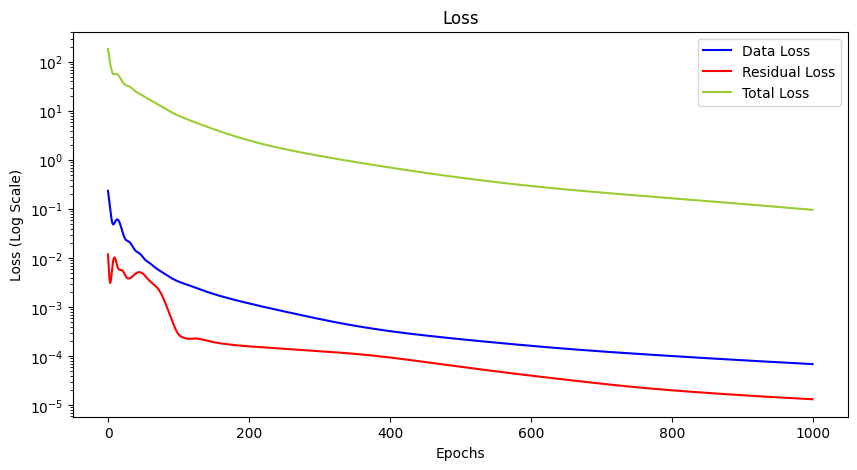

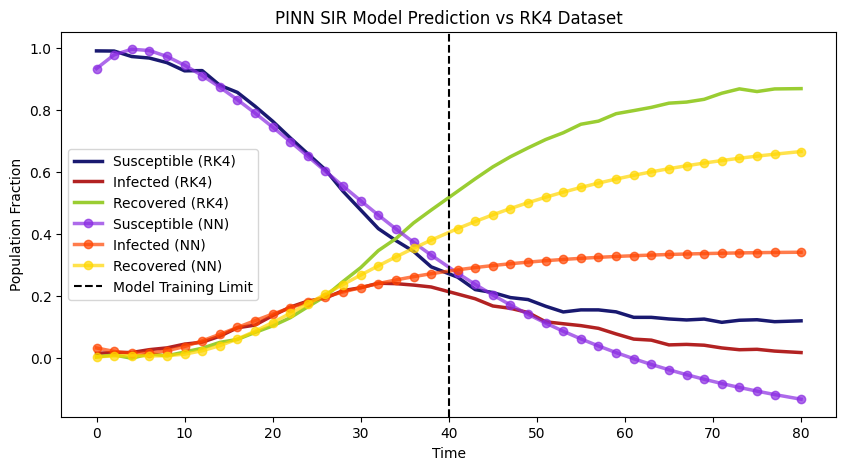

Beta: 0.25
Gamma: 0.10000000149011612
Train Loss: 0.0113429371
Test Loss: 0.0487266891
10 Day Loss: 0.0522397123


In [ ]:
modelgru = PINNGRU(input_size=1, output_size=3, num_layers=1, hidden_size=64, trainable=True, beta=0.2, gamma=0.2).to(device)
train_rnn(modelgru, t_seq, u_seq, num_epochs=1000, num_info_after_iter=500, patience=50,
          weight_data=500, weight_res=500, weight_init=300, lr=1e-3)

 50%|█████     | 501/1000 [00:59<00:53,  9.32it/s]

Epoch [500/1000] | Data Loss: 0.00013314 | Residual Loss: 0.00000286 | Initial Loss: 0.00039406 | Total Loss: 0.01754069


100%|██████████| 1000/1000 [01:59<00:00,  8.37it/s]


Epoch [1000/1000] | Data Loss: 0.00004358 | Residual Loss: 0.00000173 | Initial Loss: 0.00023522 | Total Loss: 0.00688302
Stopping with best Total Loss: 0.00688302


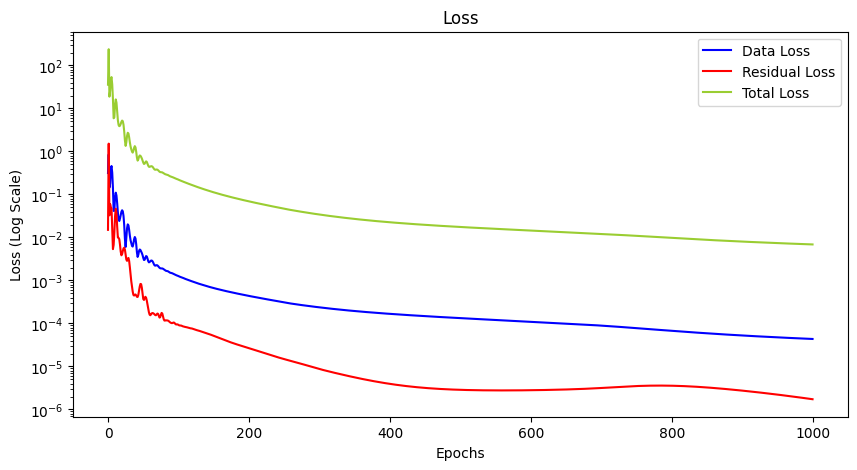

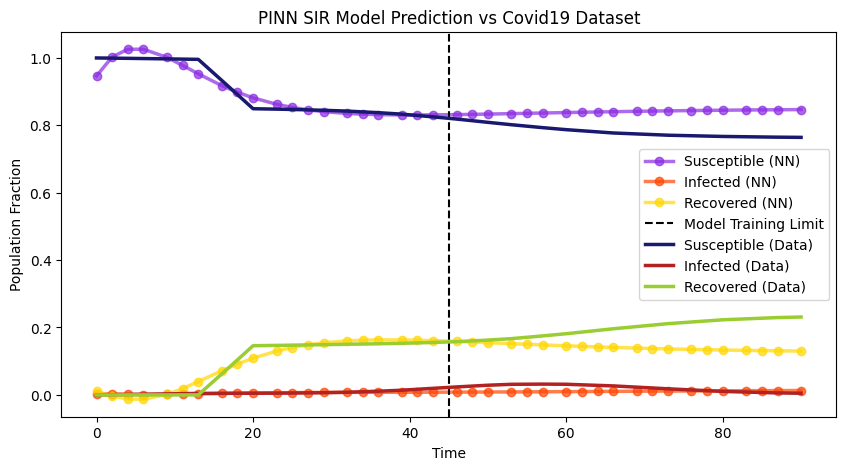

Beta: 0.19702044129371643
Gamma: 0.09891543537378311
Train Loss: 0.0004419747
Test Loss: 0.0041068299
10 Day Loss: 0.0015853401


In [ ]:
modelgru = PINNGRU(input_size=1, output_size=3, num_layers=1, trainable=True, beta=0.2, gamma=0.2).to(device)
train_rnn(modelgru, t_seq_covid, u_seq_covid, num_epochs=1000, num_info_after_iter=500,
          patience=500, weight_data=100, weight_res=100, weight_init=10, lr=1e-2, plot_rk4=False)

 25%|██▌       | 500/2000 [01:41<06:46,  3.69it/s]

Epoch [500/2000] | Data Loss: 0.00025073 | Residual Loss: 0.00000148 | Initial Loss: 0.00199134 | Total Loss: 0.45727515


 50%|█████     | 1000/2000 [03:23<04:28,  3.72it/s]

Epoch [1000/2000] | Data Loss: 0.00003881 | Residual Loss: 0.00000051 | Initial Loss: 0.00010917 | Total Loss: 0.05225072


 75%|███████▌  | 1500/2000 [05:05<02:10,  3.82it/s]

Epoch [1500/2000] | Data Loss: 0.00002740 | Residual Loss: 0.00000028 | Initial Loss: 0.00004945 | Total Loss: 0.03373590


100%|██████████| 2000/2000 [06:46<00:00,  4.92it/s]

Epoch [2000/2000] | Data Loss: 0.00002528 | Residual Loss: 0.00000019 | Initial Loss: 0.00004275 | Total Loss: 0.03051153
Stopping with best Total Loss: 0.03049587


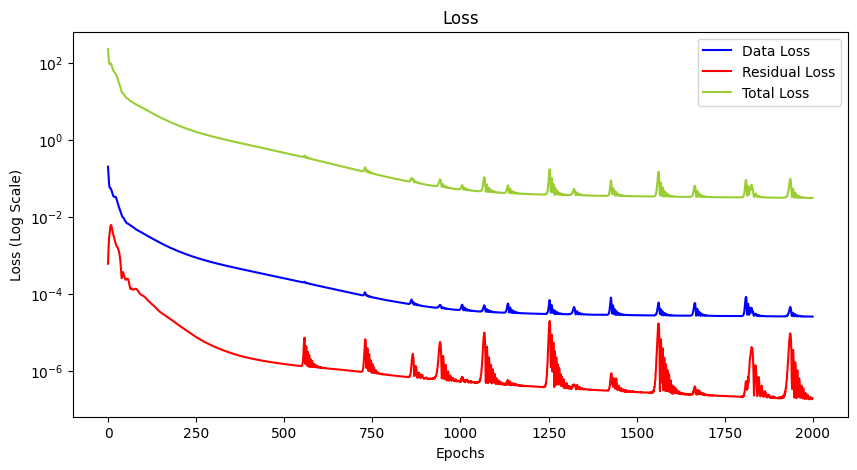

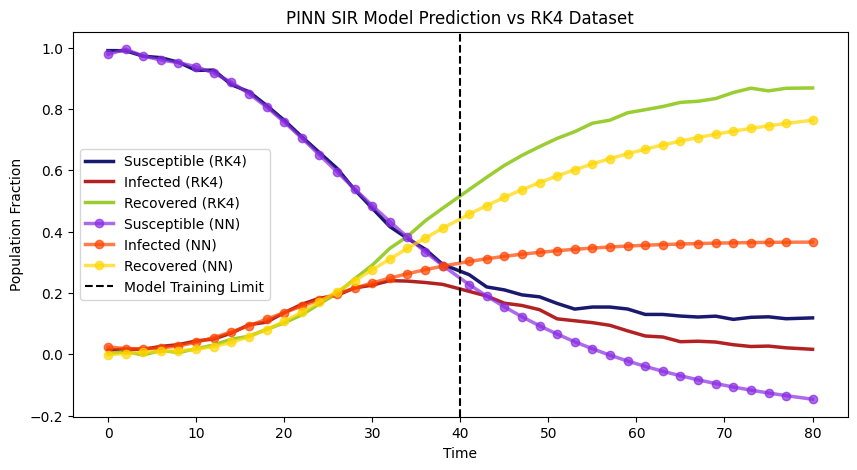

Beta: 0.17709656059741974
Gamma: 0.09459385275840759
Train Loss: 0.0443749949
Test Loss: 0.1572356075
10 Day Loss: 0.2217815965


In [ ]:
modelstm = PINNLSTM(input_size=1, output_size=3, num_layers=1, trainable=True, beta=0.2, gamma=0.2).to(device)
train_rnn(modelstm, t_seq, u_seq, num_epochs=2000, num_info_after_iter=500, patience=500,
          weight_data=1000, weight_res=5000, weight_init=100, lr=1e-3)

 50%|█████     | 500/1000 [01:40<01:33,  5.34it/s]

Epoch [500/1000] | Data Loss: 0.00004860 | Residual Loss: 0.00000325 | Initial Loss: 0.00022237 | Total Loss: 0.00740891


100%|██████████| 1000/1000 [03:20<00:00,  5.00it/s]


Epoch [1000/1000] | Data Loss: 0.00002236 | Residual Loss: 0.00000086 | Initial Loss: 0.00012764 | Total Loss: 0.00359820
Stopping with best Total Loss: 0.00359820


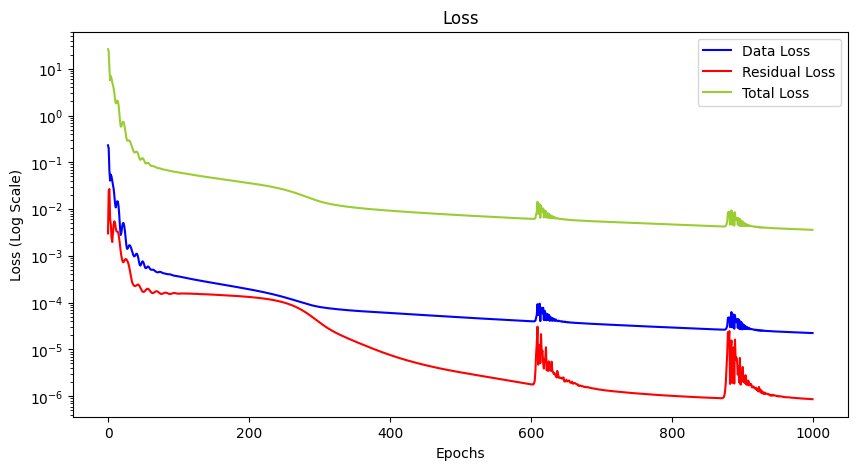

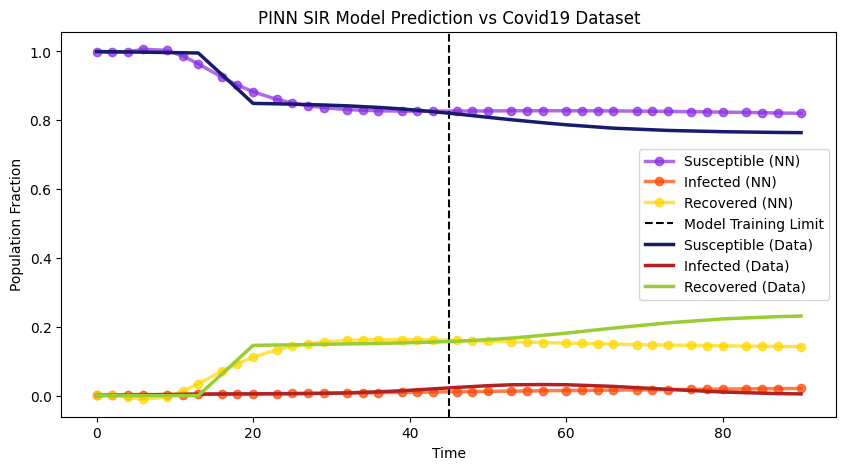

Beta: 0.18413046002388
Gamma: 0.13025535643100739
Train Loss: 0.0004475524
Test Loss: 0.0014105450
10 Day Loss: 0.0003216001


In [ ]:
modelstm = PINNLSTM(input_size=1, output_size=3, num_layers=1, trainable=True, beta=0.2, gamma=0.2).to(device)
train_rnn(modelstm, t_seq_covid, u_seq_covid, num_epochs=1000, num_info_after_iter=500,
          patience=500, weight_data=100, weight_res=100, weight_init=10, lr=1e-2, plot_rk4=False)

## Conv1D

In [ ]:
class Conv1DNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=3, hidden_channels=64, kernel_size=3, num_layers=3, act_func=nn.ReLU(), trainable=False):
        super(Conv1DNet, self).__init__()

        if trainable:
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32))
        else:
            self.beta = beta
            self.gamma = gamma

        self.initial_layer = nn.Sequential(
            nn.Conv1d(in_channels, hidden_channels, kernel_size, padding=kernel_size//2),
            nn.BatchNorm1d(hidden_channels),
            act_func
        )

        self.residual_layers = nn.Sequential(*[
            nn.Sequential(
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(hidden_channels),
                act_func,
                nn.Conv1d(hidden_channels, hidden_channels, kernel_size, padding=kernel_size//2),
                nn.BatchNorm1d(hidden_channels)
            ) for _ in range(num_layers - 2)
        ])

        self.final_layer = nn.Sequential(
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(hidden_channels, out_channels)
        )

    def forward(self, x):
        x = self.initial_layer(x)
        for res_block in self.residual_layers:
            x = x + res_block(x)  # Residual connection
        x = self.final_layer(x)
        return x

In [ ]:
t_cnn = t_model.unsqueeze(0).permute(0, 2, 1)  # Shape becomes (1, 1, 41)
u_cnn = u_model.unsqueeze(0)  # Shape becomes (1, 41, 3)

conv = Conv1DNet(hidden_channels=64, num_layers=3, act_func=nn.ReLU()).to(device)
plot_results(conv, t_tensor, u_tensor, T_model)

In [ ]:
train(conv, t_cnn, u_cnn, num_epochs=5000, num_info_after_iter=500, lr=1e-3, weight_data=10.0, weight_res=5.0, patience=100)

## Data


In [ ]:
!pip install delphi-epidata --quiet
import pandas as pd
from delphi_epidata import Epidata

In [ ]:
# Define constants
US_POPULATION = 331_000_000  # Approximate US population
RECOVERY_DAYS = 14  # Recovery period for R estimation
start_date = "20200201"  # Start date for time series
end_date = "20220501"  # End date for time series

# Fetch time series of cumulative cases, deaths, and new cases
def fetch_epidata(signal):
    response = Epidata.covidcast(
        data_source="jhu-csse",
        signals=signal,
        time_type="day",
        geo_type="nation",
        geo_value="us",
        time_values=f"{start_date}-{end_date}"
    )
    if response["result"] == 1:
        return {entry["time_value"]: entry["value"] for entry in response["epidata"]}
    else:
        raise ValueError(f"Failed to retrieve {signal} data")

# Get data for cases, deaths, and new daily cases
cases_data = fetch_epidata("confirmed_cumulative_num")
deaths_data = fetch_epidata("deaths_cumulative_num")
new_cases_data = fetch_epidata("confirmed_incidence_num")

# Create full date range
dates = sorted(cases_data.keys())
df = pd.DataFrame({"Date": dates})
df["Cases"] = df["Date"].map(cases_data)
df["Deaths"] = df["Date"].map(deaths_data)

# Compute rolling recoveries (sum of past 14 days of new cases)
df["Recovered"] = df["Date"].map(lambda d: sum(new_cases_data.get(d - i, 0) for i in range(RECOVERY_DAYS)))

# Compute SIR compartments
df["S"] = US_POPULATION - df["Cases"]
df["I"] = df["Cases"] - (df["Recovered"] + df["Deaths"])
df["R"] = df["Recovered"] + df["Deaths"]

# Keep only necessary columns
df = df[["Date", "S", "I", "R"]]

# Print first few rows
print(df.head())

import matplotlib.pyplot as plt

# Convert Date to datetime format for better plotting
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

# Plot S, I, R over time
plt.figure(figsize=(12, 6))
plt.plot(df["Date"], df["S"], label="Susceptible (S)", color="blue")
plt.plot(df["Date"], df["I"], label="Infected (I)", color="red")
plt.plot(df["Date"], df["R"], label="Recovered (R)", color="green")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Population Count")
plt.title("SIR Model Data Over Time")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

ValueError: Failed to retrieve confirmed_incidence_num data

In [ ]:
from delphi_epidata import Epidata
print(Epidata.covidcast_meta())


{'result': 0, 'message': 'error: 500 Server Error: INTERNAL SERVER ERROR for url: https://api.delphi.cmu.edu/epidata/covidcast_meta/'}


In [ ]:
# Define the selected interval
start_date = "20210901"  # Start date for time series
end_date = "20220501"  # End date for time series

# Convert Date column to datetime format
df["Date"] = pd.to_datetime(df["Date"], format="%Y%m%d")

# Filter data for the selected time interval
df_filtered = df[(df["Date"] >= start_date) & (df["Date"] <= end_date)]

# Plot S, I, R over the selected time period
plt.figure(figsize=(12, 6))
plt.plot(df_filtered["Date"], df_filtered["S"], label="Susceptible (S)", color="blue")
plt.plot(df_filtered["Date"], df_filtered["I"], label="Infected (I)", color="red")
plt.plot(df_filtered["Date"], df_filtered["R"], label="Recovered (R)", color="green")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Population Count")
plt.title("SIR Model Data (Jan 15 – Mar 01)")
plt.legend()
plt.grid(True)

# Show plot
plt.show()

NameError: name 'df' is not defined

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# Convert dates to numeric time steps
df_filtered["Time"] = (df_filtered["Date"] - df_filtered["Date"].min()).dt.days
t_data = df_filtered["Time"].values
S_data = df_filtered["S"].values
I_data = df_filtered["I"].values
R_data = df_filtered["R"].values

# Define the SIR model differential equations
def sir_model(y, t, beta, gamma):
    S, I, R = y
    dSdt = -beta * S * I / US_POPULATION
    dIdt = beta * S * I / US_POPULATION - gamma * I
    dRdt = gamma * I
    return [dSdt, dIdt, dRdt]

# Function for curve fitting
def fit_sir(t, beta, gamma):
    y0 = [S_data[0], I_data[0], R_data[0]]  # Initial conditions
    solution = odeint(sir_model, y0, t, args=(beta, gamma))
    return solution[:, 1]  # Fit only to Infected (I) data

# Initial parameter guesses
beta_guess = 0.3
gamma_guess = 0.1

# Fit the SIR model to actual infected data
params, _ = curve_fit(fit_sir, t_data, I_data, p0=[beta_guess, gamma_guess], bounds=(0, [1.0, 1.0]))
beta_fit, gamma_fit = params

# Solve the SIR model using the fitted parameters
solution = odeint(sir_model, [S_data[0], I_data[0], R_data[0]], t_data, args=(beta_fit, gamma_fit))
S_fit, I_fit, R_fit = solution.T

# Plot actual vs fitted for S, I, R
plt.figure(figsize=(12, 6))

# Infected
plt.scatter(df_filtered["Date"], I_data, label="Actual Infected", color="red", marker="o")
plt.plot(df_filtered["Date"], I_fit, label="Fitted Infected", color="red", linestyle="dashed")

# Recovered
plt.scatter(df_filtered["Date"], R_data, label="Actual Recovered", color="green", marker="o")
plt.plot(df_filtered["Date"], R_fit, label="Fitted Recovered", color="green", linestyle="dashed")

# Susceptible
plt.scatter(df_filtered["Date"], S_data, label="Actual Susceptible", color="blue", marker="o")
plt.plot(df_filtered["Date"], S_fit, label="Fitted Susceptible", color="blue", linestyle="dashed")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Population Count")
plt.title(f"SIR Model Fitting (β = {beta_fit:.4f}, γ = {gamma_fit:.4f})")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Print estimated parameters
print(f"Estimated β (infection rate): {beta_fit:.4f}")
print(f"Estimated γ (recovery rate): {gamma_fit:.4f}")
print(f"Estimated R0 (basic reproduction number): {beta_fit / gamma_fit:.2f}")

## SINDy


In [ ]:
!pip install pysindy --quiet
import pysindy as ps
#from pysindy.feature_library import CustomLibrary

In [ ]:
np.random.seed(20240813)
np.math = math

beta = 0.25
gamma = 0.1
start = [0.99, 0.01, 0.00]
T_data = 80
T_model = 40
n = T_data

t_values, u_values = ERK4(SIR, T_data, n, start)
noise_level = 0.005
u_values += np.random.normal(0, noise_level, u_values.shape)
t_train = t_values[t_values <= T_model]
u_train = u_values[t_values <= T_model]

def sindy(labda):
    differentiation = ps.differentiation.SmoothedFiniteDifference()
    sindy = ps.SINDy(
        feature_library=ps.PolynomialLibrary(degree=2),
        optimizer=ps.STLSQ(threshold=labda)
    )
    sindy.fit(u_train, t=t_train)
    sindy.print()
    t_forecast = np.linspace(0, T_data, 100 * len(t_values))
    u_forecast = sindy.simulate(start, t_forecast)
    return t_forecast, u_forecast

t_forecast, u_forecast = sindy(0.005)

plt.figure(figsize=(10, 5))
plt.plot(t_values, u_values[:, 0], label='Susceptible (RK4)', c='firebrick', lw=2.5)
plt.plot(t_values, u_values[:, 1], label='Infected (RK4)', c='yellowgreen', lw=2.5)
plt.plot(t_values, u_values[:, 2], label='Recovered (RK4)', c='midnightblue', lw=2.5)
plt.plot(t_forecast[:len(u_forecast)], u_forecast[:, 0], '--', label='Susceptible (SINDy)', c='orangered', lw=2.5, alpha=0.7)
plt.plot(t_forecast[:len(u_forecast)], u_forecast[:, 1], '--', label='Infected (SINDy)', c='gold', lw=2.5, alpha=0.7)
plt.plot(t_forecast[:len(u_forecast)], u_forecast[:, 2], '--', label='Recovered (SINDy)', c='blueviolet', lw=2.5, alpha=0.7)
plt.axvline(T_model, linestyle='--', color='k', label='Model Training Limit')
plt.title('SINDy Model Prediction vs RK4 Simulation')
plt.xlabel('Time')
plt.ylabel('Population Fraction')
plt.legend()
plt.show()